# **MNIST Teacher Student CNN**


En este notebook se creara un red neuronal utilizando la arquitectura de CNN(Convulational Neural Network).

In [3]:
#Run this if you want to force to use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import numpy as np 
from keras import layers, models
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt



## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2, l1

import tensorflow_model_optimization as tfmot

## Pruning
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Knowledge Distillation
from src.distillationClassKeras import *

## Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

## Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

## Training
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras.optimizers import RMSprop

In [6]:
(train_data, train_labels) , (test_data, test_labels) = mnist.load_data()

In [7]:
train_data.shape 

(60000, 28, 28)

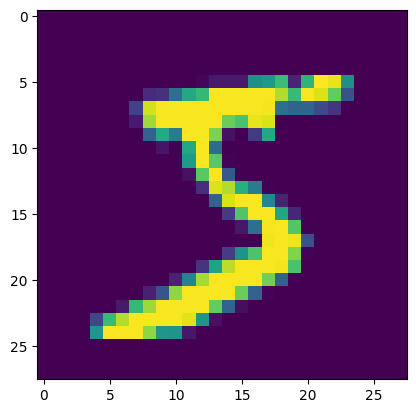

In [8]:
plt.imshow(train_data[0]) #Imagen de ejemplo del MNIST



## Teacher Training

Los hiperparámetros que definen la arquitectura del modelo *Teacher* son:

* Learning rate
* Número de neuronas
* Número de filtros




In [9]:
# Define the hyperparameters for the teacher model
lr = 0.01 #Learning Rate
neurons_teacher = [124, 64] #Numero de neuronas
filters_teacher = [32,64] #Numero de filtros

### Topologia del modelo Teacher

El input esta dado por la forma de la imagen del mnist (28,28,1) y ofrece una salida de 10, que corresponde a los numeros del 0 al 9

In [10]:
def teacher_topology(bestHP_filters, bestHP_neurons):

    teacher = keras.models.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),   # MNIST con canal

            # ---- BLOQUE CONVOLUCIONAL 1 ----
            Conv2D(bestHP_filters[0], (3,3), activation='relu', kernel_regularizer=l2(0.001), name='conv1'),
            MaxPooling2D((2,2), name='pool1'),

            # ---- BLOQUE CONVOLUCIONAL 2 ----
            Conv2D(bestHP_filters[1], (3,3), activation='relu', kernel_regularizer=l2(0.001), name='conv2'),
            MaxPooling2D((2,2), name='pool2'),

            # ---- BLOQUE DENSO ----
            Flatten(name='flat'),

            Dense(bestHP_neurons[0], activation='relu', kernel_regularizer=l2(0.001), name='fc1'),
            Dense(bestHP_neurons[1], activation='relu', kernel_regularizer=l2(0.001), name='fc2'),

            Dropout(0.1, name='drop1'),

            Dense(10, activation='softmax', name='output'),
        ],
        name="teacher_CNN",
    )

    teacher.summary()
    return teacher

Para la construccion del modelo teacher, se utiliza el optimizador *Adam* que coge de parametro el learning rate, y utilizamos la funcion de perdidas *categorical_crossentropy* y metricas *accuaracy*

In [11]:
 

def build_teacher(filters_teacher, neurons_teacher):

    model = teacher_topology(filters_teacher, neurons_teacher)
       
    opt = Adam(learning_rate=lr)
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


teacher_model = build_teacher(filters_teacher, neurons_teacher)

Model: "teacher_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 11, 11, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 64)          0         
                                                                 
 flat (Flatten)              (None, 1600)              0         
                                                                 
 fc1 (Dense)                 (None, 124)               198524    
                                                                 
 fc2 (Dense)                 (None, 64)                

2025-12-09 14:26:30.955810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-12-09 14:26:30.955870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pinpatom
2025-12-09 14:26:30.955887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pinpatom
2025-12-09 14:26:30.956097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 580.82.7
2025-12-09 14:26:30.956150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 580.82.7
2025-12-09 14:26:30.956165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 580.82.7


In [12]:
# Normalización a float32
x_train = train_data.astype("float32") / 255.0
x_test  = test_data.astype("float32") / 255.0

# Reshape para Conv2D: (N, 28, 28, 1)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding de las etiquetas
y_train = to_categorical(train_labels, 10)
y_test  = to_categorical(test_labels, 10)

In [13]:
callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=1, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.4, patience=3, verbose=1)
            ] 

history_teacher  = teacher_model.fit(x=x_train, y=y_train,
                  validation_data=(x_test, y_test), 
                  batch_size = 64,
                  epochs=32,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/32


2025-12-09 14:26:31.397188: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


938/938 [==============================] - 20s 20ms/step - loss: 0.3719 - accuracy: 0.9454 - val_loss: 0.2372 - val_accuracy: 0.9707 - lr: 0.0100
Epoch 2/32
938/938 [==============================] - 19s 20ms/step - loss: 0.2571 - accuracy: 0.9654 - val_loss: 0.2179 - val_accuracy: 0.9739 - lr: 0.0100
Epoch 3/32
938/938 [==============================] - 19s 20ms/step - loss: 0.2262 - accuracy: 0.9689 - val_loss: 0.1930 - val_accuracy: 0.9750 - lr: 0.0100
Epoch 4/32
938/938 [==============================] - 19s 20ms/step - loss: 0.2145 - accuracy: 0.9704 - val_loss: 0.1911 - val_accuracy: 0.9751 - lr: 0.0100
Epoch 5/32
938/938 [==============================] - 20s 21ms/step - loss: 0.2072 - accuracy: 0.9706 - val_loss: 0.1880 - val_accuracy: 0.9728 - lr: 0.0100
Epoch 6/32
938/938 [==============================] - 20s 21ms/step - loss: 0.2008 - accuracy: 0.9711 - val_loss: 0.2274 - val_accuracy: 0.9620 - lr: 0.0100
Epoch 7/32
938/938 [==============================] - 20s 21ms/step -

### **Conceptos clave**

En aprendizaje automático, la *accuracy* (precisión) mide qué proporción de predicciones son correctas. Durante el entrenamiento se suelen mostrar dos curvas: la precisión sobre los datos de **entrenamiento**, que indica qué tan bien el modelo aprende de los ejemplos que ya ha visto, y la precisión de **validación**, que muestra qué tan bien generaliza a datos nuevos que no vio durante el entrenamiento. Si ambas curvas suben y se mantienen cercanas, significa que el modelo está aprendiendo correctamente y no está memorizando los datos (sobreajuste). Por otro lado, si la precisión de entrenamiento sube mientras la de validación baja o se estanca, puede indicar problemas de *overfitting*.




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


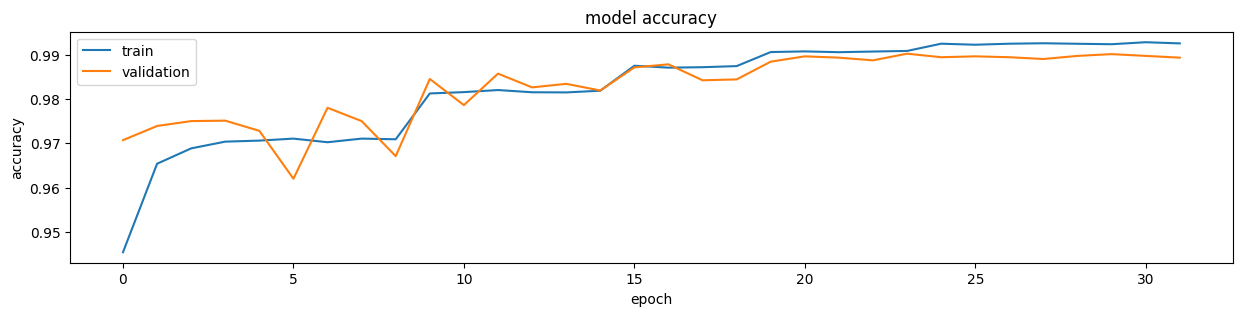

<Figure size 640x480 with 0 Axes>

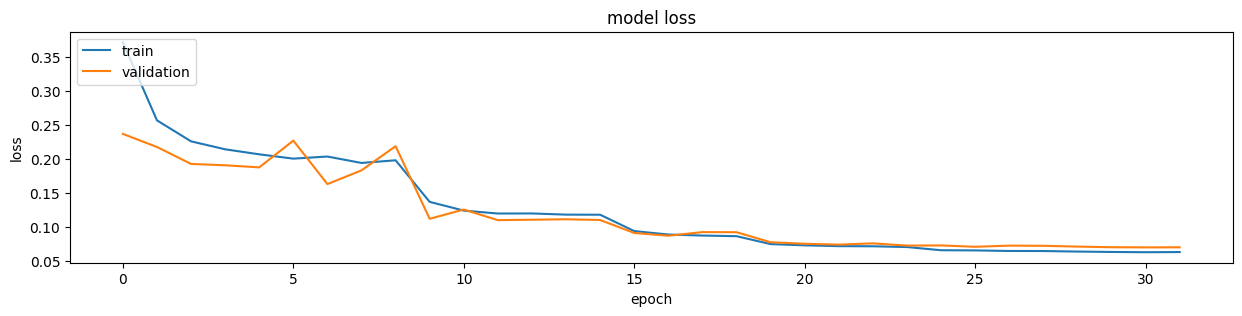

In [14]:
print(history_teacher.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['accuracy'])
plt.plot(history_teacher.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_teacher.history['loss'])
plt.plot(history_teacher.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

En las gráficas mostradas se observa que tanto la precisión de entrenamiento como la de validación aumentan de forma rápida al inicio y luego se estabilizan alrededor del 99%, manteniéndose muy cercanas entre sí. Esto sugiere que el modelo ha aprendido de manera adecuada el conjunto MNIST y logra generalizar bien a los datos nuevos. No hay evidencia de sobreajuste importante, ya que ambas curvas siguen trayectorias similares y se mantienen estables. En conjunto, las métricas indican que el modelo alcanza un desempeño excelente y un entrenamiento equilibrado.

### **Qué es una matriz de confusión**

Una matriz de confusión es una herramienta que permite evaluar el rendimiento de un modelo de clasificación mostrando cuántos ejemplos fueron predichos correctamente y cuántos fueron confundidos con otras clases. Cada fila representa la **etiqueta verdadera**, mientras que cada columna representa la **predicción del modelo**. Los valores en la diagonal indican aciertos: cuantos más valores altos haya allí, mejor es el rendimiento. Los valores fuera de la diagonal indican errores y muestran específicamente qué clases se confunden entre sí, lo que ayuda a identificar patrones de fallo del modelo.



313/313 [==============================] - 1s 4ms/step


<Figure size 700x700 with 0 Axes>

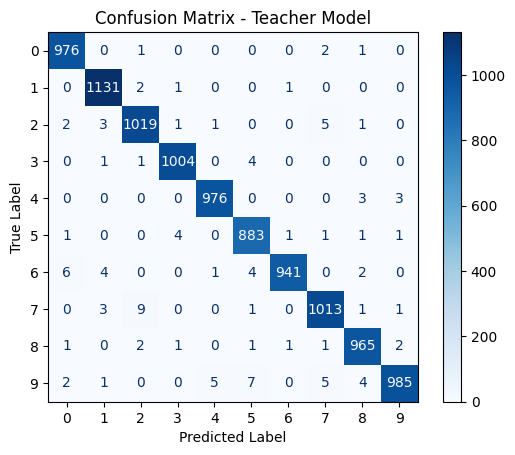

In [15]:
# 1. Predecir probabilidades
y_pred_probs = teacher_model.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


La matriz de confusión del *Teacher Model* indica un rendimiento excelente: la diagonal contiene valores muy altos, lo que significa que casi todas las imágenes de cada dígito fueron clasificadas correctamente. Los errores son pocos y dispersos, típicamente confusiones muy comunes en MNIST, como algunos “5” predichos como “3” o algunos “8” confundidos con “9”. Las clases con más precisión incluyen los dígitos 1, 7 y 9, que muestran muy pocos errores. En general, los resultados reflejan un modelo robusto y altamente preciso, con un comportamiento consistente con modelos bien entrenados en MNIST.


In [16]:
teacher_model.save('models/CNN/teacherModelMnistCNN.h5')

# **Pruning**


El pruning es una técnica utilizada para reducir el tamaño y la complejidad de un modelo de deep learning mediante la eliminación de pesos o neuronas que se consideran poco relevantes. El objetivo principal es mejorar la eficiencia del modelo reduciendo el consumo de memoria y acelerando la inferencia, todo ello sin afectar de manera significativa la precisión final del modelo.



In [17]:
epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2

final_sparsity = 0.5

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=1000
                )
            }

callbacks.append(pruning_callbacks.UpdatePruningStep())

In [18]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(teacher_model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

In [19]:
history_P  = modelP.fit(x=x_train, y=y_train,
                  validation_split = val_split,
                  batch_size = 64,
                  epochs=32,
                  callbacks = [callbacks],
                  verbose=1
                  )   

Epoch 1/32


2025-12-09 14:37:56.023795: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


750/750 [==============================] - 24s 26ms/step - loss: 0.0722 - accuracy: 0.9891 - val_loss: 0.0740 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 2/32
750/750 [==============================] - 19s 26ms/step - loss: 0.0723 - accuracy: 0.9898 - val_loss: 0.0736 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 3/32
750/750 [==============================] - 21s 28ms/step - loss: 0.0723 - accuracy: 0.9900 - val_loss: 0.0753 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 4/32
750/750 [==============================] - 20s 26ms/step - loss: 0.0712 - accuracy: 0.9900 - val_loss: 0.0787 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 5/32
750/750 [==============================] - 19s 26ms/step - loss: 0.0715 - accuracy: 0.9901 - val_loss: 0.0787 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 6/32
750/750 [==============================] - 19s 26ms/step - loss: 0.0708 - accuracy: 0.9909 - val_loss: 0.0840 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 7/32
750/750 [==============================] - 21s 28ms/step -

**¿Por qué el *pruning* terminó antes?**

El entrenamiento estaba configurado para 32 épocas, pero el *pruning* solo estaba programado hasta el **step 1000**. Como un *step* es un batch y no una época, el modelo llegó rápidamente a esos 1000 steps, por lo que la poda finalizó antes aunque el entrenamiento continuara.


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


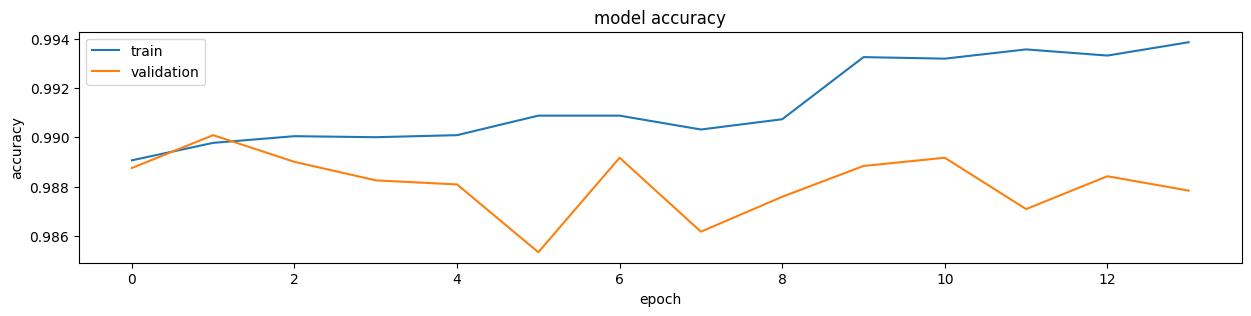

<Figure size 640x480 with 0 Axes>

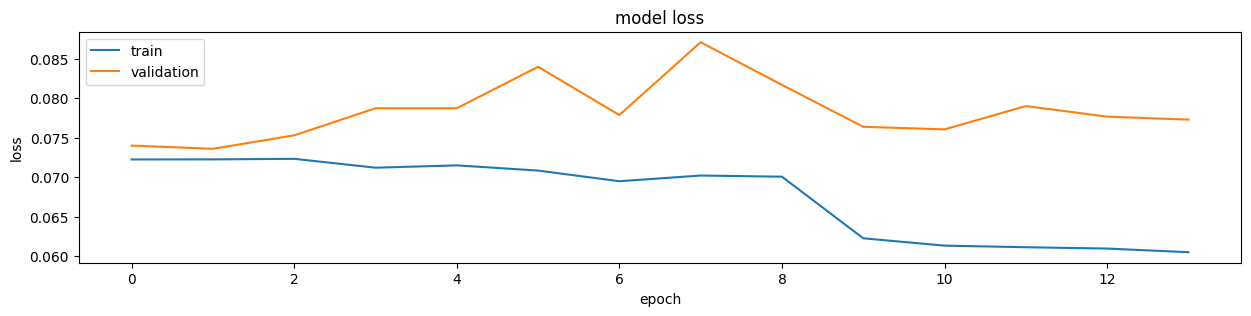

In [20]:
print(history_P.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_P.history['accuracy'])
plt.plot(history_P.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_P.history['loss'])
plt.plot(history_P.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

313/313 [==============================] - 2s 4ms/step


<Figure size 700x700 with 0 Axes>

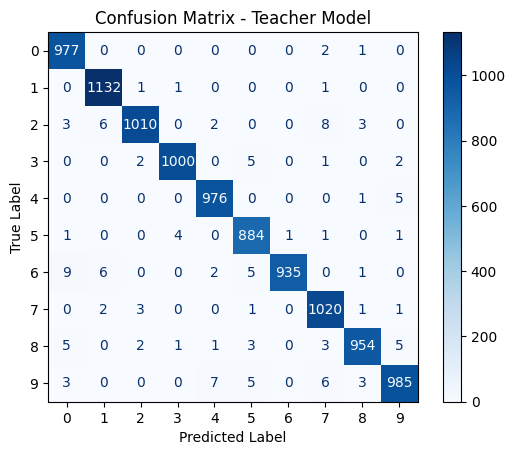

In [21]:
# 1. Predecir probabilidades
y_pred_probs =modelP.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [22]:
modelP.save('models/CNN/teacherModelMnistCNN_pruned.h5')

### **Quantization**


Es una técnica que reduce la precisión numérica de los parámetros de una red neuronal al convertir valores en punto flotante de **32 bits** a representaciones más pequeñas, como **16 bits** o incluso **8 bits**. El objetivo es disminuir el tamaño del modelo, mejorar la velocidad de inferencia y permitir que funcione en dispositivos con recursos limitados.

Para este caso se utilizan **quantization-aware training** (QAT) y **quantization-aware pruning** (QAP):

* **QAT** es una técnica en la que el modelo aprende a adaptarse a la cuantización durante el entrenamiento. En lugar de entrenar el modelo por completo y cuantificarlo al final, la cuantización se introduce desde el proceso de entrenamiento para que el modelo aprenda a trabajar bajo esa restricción numérica.

* **QAP** combina el *pruning* con QAT. La idea es reducir el modelo a través de poda antes de cuantificarlo, logrando una red más eficiente en tamaño y velocidad sin sacrificar la precisión.




In [23]:
# Estrategia de cuantización – 8 bits
# -----------------------------
# Cuantizadores
# -----------------------------
kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ   = "quantized_bits(8,4,alpha=1)"
activationQ = "quantized_bits(8,4)"

# -----------------------------
# Hiperparámetros EDITABLES
# -----------------------------
filters_conv = [16, 32]          # <-- FILTROS CONV
neurons_teacher = [124, 64]      # <-- NEURONAS DENSAS

# -----------------------------
# MODELO QAT SECUENCIAL (ESTILO MLP + CONV)
# -----------------------------
modelQAT = Sequential(
    [
        
        keras.Input(shape=(28, 28, 1)),

        # ----------- CONV 1 -----------
        QConv2D(
            filters_conv[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
            name="conv1",
        ),
        QActivation(activation=activationQ, name="conv1_act"),
        MaxPooling2D(pool_size=(2, 2), name="pool1"),

        # ----------- CONV 2 -----------
        QConv2D(
            filters_conv[1],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
            name="conv2",
        ),
        QActivation(activation=activationQ, name="conv2_act"),
        MaxPooling2D(pool_size=(2, 2), name="pool2"),

        # ----------- FLATTEN -----------
        Flatten(name="flatten"),

        # ----------- FC1 -----------
        QDense(
            neurons_teacher[0], 
            name="fc1",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
        ),
        QActivation(activation=activationQ, name="relu1"),

        # ----------- FC2 -----------
        QDense(
            neurons_teacher[1],
            name="fc2",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
        ),
        QActivation(activation=activationQ, name="relu2"),

        # ----------- DROPOUT -----------
        Dropout(0.1, name="drop1"),

        # ----------- OUTPUT -----------
        QDense(
            10,
            name="output",
            kernel_quantizer=kernelQ,
            bias_quantizer=biasQ,
            kernel_initializer="lecun_uniform",
        ),
        QActivation("softmax", name="softmax"),
    ],
    name="quantized_teacher_CNN_MLP",
)

modelQAT.summary()


/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "quantized_teacher_CNN_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv1_act (QActivation)     (None, 26, 26, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 16)        0         
                                                                 
 conv2 (QConv2D)             (None, 11, 11, 32)        4640      
                                                                 
 conv2_act (QActivation)     (None, 11, 11, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 32)          0         
                                                                 
 flatten (Flatten)           (None, 800) 

In [24]:
# Model Training

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAT = modelQAT.fit(x=x_train, y=y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )

Epoch 1/16


2025-12-09 14:42:41.369958: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.


1500/1500 [==============================] - 25s 15ms/step - loss: 0.6910 - accuracy: 0.8602 - val_loss: 0.2149 - val_accuracy: 0.9436
Epoch 2/16
1500/1500 [==============================] - 20s 13ms/step - loss: 0.2715 - accuracy: 0.9304 - val_loss: 0.1885 - val_accuracy: 0.9563
Epoch 3/16
1500/1500 [==============================] - 17s 12ms/step - loss: 0.2315 - accuracy: 0.9426 - val_loss: 0.1965 - val_accuracy: 0.9548
Epoch 4/16
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2053 - accuracy: 0.9477 - val_loss: 0.2744 - val_accuracy: 0.9430
Epoch 5/16
1500/1500 [==============================] - 19s 13ms/step - loss: 0.1900 - accuracy: 0.9547 - val_loss: 0.1809 - val_accuracy: 0.9580
Epoch 6/16
1500/1500 [==============================] - 19s 12ms/step - loss: 0.1816 - accuracy: 0.9570 - val_loss: 0.1541 - val_accuracy: 0.9638
Epoch 7/16
1500/1500 [==============================] - 19s 13ms/step - loss: 0.1726 - accuracy: 0.9579 - val_loss: 0.1888 - val_accura

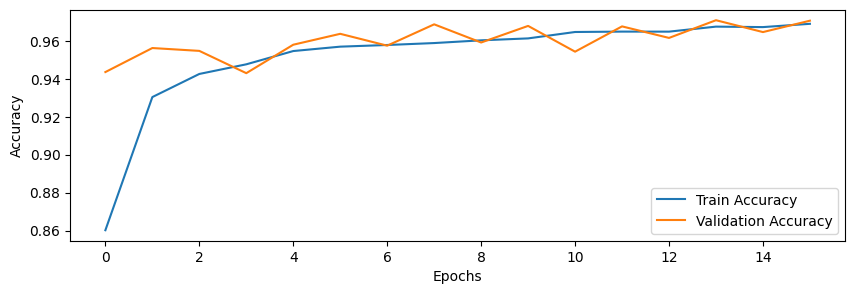

In [25]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(historyQAT.history['accuracy'], label='Train Accuracy')
plt.plot(historyQAT.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 2s 5ms/step


<Figure size 700x700 with 0 Axes>

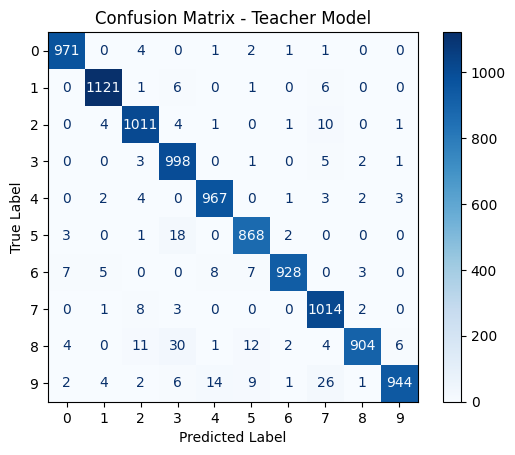

In [26]:
# 1. Predecir probabilidades
y_pred_probs =modelQAT.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
modelQAT.save('models/CNN/teacherModelQATMnistCNN.h5')

# **Student network** 

Para implementar un modelo de red neuronal en una FPGA, se reduce el tamaño del modelo *Teacher* creando un modelo *Student* mediante **Knowledge Distillation (KD)**. Este método consiste en transferir el conocimiento del modelo *Teacher* al *Student*, permitiendo que el modelo más pequeño mantenga un rendimiento similar al del modelo original.


In [28]:
lr = 0.01
neurons_student = [64,32]

In [29]:
def student_topology(neurons_student):

    '''
    Model to be trained. Defined with quantization strategies. 
    Input: hyperparams. (neurons_student)
    Output: compressed model (studentQ_CNN_MLP). 
    '''

    # -----------------------------
    # Cuantización
    # -----------------------------

    ## 4-bits
    kernelQ_4b = "quantized_bits(4,2,alpha=1)"
    biasQ_4b   = "quantized_bits(4,2,alpha=1)"
    activationQ_4b = "quantized_bits(4,0)"

    ## 8-bits (PRINCIPAL)
    kernelQ = "quantized_bits(8,4,alpha=1)"
    biasQ   = "quantized_bits(8,4,alpha=1)"
    activationQ = "quantized_bits(8)"

    ## 16-bits (SALIDA)
    kernelQ_16b = "quantized_bits(16,6,alpha=1)"
    biasQ_16b   = "quantized_bits(16,6,alpha=1)"
    activationQ_16b = "quantized_bits(16)"

    # -----------------------------
    # MODELO STUDENT QAT (CNN + MLP)
    # -----------------------------
    studentQ_CNN_MLP = Sequential(
        [
            # ----------- INPUT -----------
            Input(shape=(28, 28, 1), name="inputLayer"),

            # ----------- CONV 1 -----------
            QConv2D(
                16, 
                (3, 3),
                strides=(1, 1),
                padding="valid",
                kernel_quantizer=kernelQ,
                bias_quantizer=biasQ,
                kernel_initializer="lecun_uniform",
                name="conv1",
            ),
            QActivation(activation=activationQ, name="conv1_act"),
            MaxPooling2D(pool_size=(2, 2), name="pool1"),

            # ----------- CONV 2 -----------
            QConv2D(
                32, 
                (3, 3),
                strides=(1, 1),
                padding="valid",
                kernel_quantizer=kernelQ,
                bias_quantizer=biasQ,
                kernel_initializer="lecun_uniform",
                name="conv2",
            ),
            QActivation(activation=activationQ, name="conv2_act"),
            MaxPooling2D(pool_size=(2, 2), name="pool2"),

            # ----------- FLATTEN -----------
            Flatten(name="flatten"),

            # ----------- FC1 -----------
            QDense(
                neurons_student[0],
                kernel_quantizer=kernelQ,
                bias_quantizer=biasQ,
                kernel_initializer="lecun_uniform",
                name="fc1",
            ),
            QActivation(activation=activationQ, name="relu1"),

            # ----------- FC2 -----------
            QDense(
                neurons_student[1],
                kernel_quantizer=kernelQ,
                bias_quantizer=biasQ,
                kernel_initializer="lecun_uniform",
                name="fc2",
            ),
            QActivation(activation=activationQ, name="relu2"),

            # ----------- DROPOUT -----------
            Dropout(0.1, name="drop1"),

            # ----------- OUTPUT -----------
            QDense(
                10,
                kernel_quantizer=kernelQ_16b,   
                bias_quantizer=biasQ_16b,
                kernel_initializer="lecun_uniform",
                name="output",
            ),
            Activation("softmax", name="outputActivation"),
        ],
        name="studentQ_CNN_MLP",
    )

    studentQ_CNN_MLP.summary()
    return studentQ_CNN_MLP

In [30]:
def build_student(student_neurons):

    '''
    Model to be compressed. Defined with quantization strategies. 
    Input: hyperparams (student_neurons).
    Output: compressed model (studentQ). 

    '''
    
    qmodel = student_topology(student_neurons)

    # Pruning parameters 
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000
    )
    }
    
    studentQ = prune.prune_low_magnitude(qmodel, **pruning_params)
    
    
    return studentQ

In [31]:
studentQ = build_student(neurons_student)

distilled_student = Distiller(student=studentQ, teacher=teacher_model)

adam = Adam(lr)

train_labels = np.argmax(y_train, axis=1)

distilled_student.compile(
        optimizer=adam,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1, 
        temperature=10,
    )

Model: "studentQ_CNN_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv1_act (QActivation)     (None, 26, 26, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 16)        0         
                                                                 
 conv2 (QConv2D)             (None, 11, 11, 32)        4640      
                                                                 
 conv2_act (QActivation)     (None, 11, 11, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 32)          0         
                                                                 
 flatten (Flatten)           (None, 800)          

/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [32]:
callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, verbose=1),
                ]  

callbacks.append(pruning_callbacks.UpdatePruningStep())

history_studentQPKD = distilled_student.fit(x_train, train_labels, 
                               batch_size = 64, 
                               epochs= 32, 
                               validation_split=0.2,
                               callbacks = callbacks
                               )

Epoch 1/32


2025-12-09 14:47:50.332850: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150528000 exceeds 10% of free system memory.
/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8201 - student_loss: 0.5715 - distillation_loss: 1.2799e-04WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 22s 22ms/step - sparse_categorical_accuracy: 0.8201 - student_loss: 0.5713 - distillation_loss: 1.2796e-04 - val_sparse_categorical_accuracy: 0.8805 - val_student_loss: 0.2091 - lr: 0.0100
Epoch 2/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8618 - student_loss: 0.4519 - distillation_loss: 9.9591e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 22ms/step - sparse_categorical_accuracy: 0.8620 - student_loss: 0.4514 - distillation_loss: 9.9454e-05 - val_sparse_categorical_accuracy: 0.8904 - val_student_loss: 0.2462 - lr: 0.0100
Epoch 3/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8703 - student_loss: 0.4266 - distillation_loss: 9.3282e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 19s 25ms/step - sparse_categorical_accuracy: 0.8703 - student_loss: 0.4267 - distillation_loss: 9.3292e-05 - val_sparse_categorical_accuracy: 0.8893 - val_student_loss: 0.1610 - lr: 0.0100
Epoch 4/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8775 - student_loss: 0.4101 - distillation_loss: 8.9640e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 22ms/step - sparse_categorical_accuracy: 0.8776 - student_loss: 0.4097 - distillation_loss: 8.9564e-05 - val_sparse_categorical_accuracy: 0.8963 - val_student_loss: 0.1833 - lr: 0.0100
Epoch 5/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8779 - student_loss: 0.4076 - distillation_loss: 8.8186e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.8779 - student_loss: 0.4075 - distillation_loss: 8.8154e-05 - val_sparse_categorical_accuracy: 0.8949 - val_student_loss: 0.1413 - lr: 0.0100
Epoch 6/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8781 - student_loss: 0.4048 - distillation_loss: 8.7766e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8782 - student_loss: 0.4049 - distillation_loss: 8.7705e-05 - val_sparse_categorical_accuracy: 0.8966 - val_student_loss: 0.2156 - lr: 0.0100
Epoch 7/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8789 - student_loss: 0.4030 - distillation_loss: 8.7150e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 19ms/step - sparse_categorical_accuracy: 0.8789 - student_loss: 0.4026 - distillation_loss: 8.7085e-05 - val_sparse_categorical_accuracy: 0.8948 - val_student_loss: 0.1170 - lr: 0.0100
Epoch 8/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8798 - student_loss: 0.4010 - distillation_loss: 8.6539e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8798 - student_loss: 0.4013 - distillation_loss: 8.6636e-05 - val_sparse_categorical_accuracy: 0.8968 - val_student_loss: 0.1901 - lr: 0.0100
Epoch 9/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8810 - student_loss: 0.3945 - distillation_loss: 8.5600e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8809 - student_loss: 0.3947 - distillation_loss: 8.5666e-05 - val_sparse_categorical_accuracy: 0.8963 - val_student_loss: 0.1121 - lr: 0.0100
Epoch 10/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8822 - student_loss: 0.3906 - distillation_loss: 8.4681e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 21ms/step - sparse_categorical_accuracy: 0.8823 - student_loss: 0.3905 - distillation_loss: 8.4647e-05 - val_sparse_categorical_accuracy: 0.9031 - val_student_loss: 0.1059 - lr: 0.0100
Epoch 11/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8843 - student_loss: 0.3919 - distillation_loss: 8.4670e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8843 - student_loss: 0.3920 - distillation_loss: 8.4711e-05 - val_sparse_categorical_accuracy: 0.9001 - val_student_loss: 0.1567 - lr: 0.0100
Epoch 12/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8835 - student_loss: 0.3896 - distillation_loss: 8.4279e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.8836 - student_loss: 0.3892 - distillation_loss: 8.4246e-05 - val_sparse_categorical_accuracy: 0.8992 - val_student_loss: 0.1951 - lr: 0.0100
Epoch 13/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8845 - student_loss: 0.3876 - distillation_loss: 8.3603e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.8844 - student_loss: 0.3879 - distillation_loss: 8.3664e-05 - val_sparse_categorical_accuracy: 0.8951 - val_student_loss: 0.1224 - lr: 0.0100
Epoch 14/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8862 - student_loss: 0.3855 - distillation_loss: 8.2962e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.8862 - student_loss: 0.3856 - distillation_loss: 8.3003e-05 - val_sparse_categorical_accuracy: 0.8988 - val_student_loss: 0.1960 - lr: 0.0100
Epoch 15/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8839 - student_loss: 0.3877 - distillation_loss: 8.3864e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 22ms/step - sparse_categorical_accuracy: 0.8839 - student_loss: 0.3874 - distillation_loss: 8.3820e-05 - val_sparse_categorical_accuracy: 0.8973 - val_student_loss: 0.2043 - lr: 0.0100
Epoch 16/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8836 - student_loss: 0.3900 - distillation_loss: 8.4557e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.8836 - student_loss: 0.3901 - distillation_loss: 8.4575e-05 - val_sparse_categorical_accuracy: 0.8958 - val_student_loss: 0.2252 - lr: 0.0100
Epoch 17/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8838 - student_loss: 0.3892 - distillation_loss: 8.3948e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.8838 - student_loss: 0.3890 - distillation_loss: 8.3898e-05 - val_sparse_categorical_accuracy: 0.8973 - val_student_loss: 0.1921 - lr: 0.0100
Epoch 18/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8831 - student_loss: 0.3891 - distillation_loss: 8.4441e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8831 - student_loss: 0.3890 - distillation_loss: 8.4396e-05 - val_sparse_categorical_accuracy: 0.8967 - val_student_loss: 0.1903 - lr: 0.0100
Epoch 19/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8838 - student_loss: 0.3867 - distillation_loss: 8.3666e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 21ms/step - sparse_categorical_accuracy: 0.8838 - student_loss: 0.3867 - distillation_loss: 8.3672e-05 - val_sparse_categorical_accuracy: 0.8978 - val_student_loss: 0.1644 - lr: 0.0100
Epoch 20/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8841 - student_loss: 0.3872 - distillation_loss: 8.3950e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.8841 - student_loss: 0.3876 - distillation_loss: 8.4023e-05 - val_sparse_categorical_accuracy: 0.8921 - val_student_loss: 0.1826 - lr: 0.0100
Epoch 21/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8833 - student_loss: 0.3888 - distillation_loss: 8.3978e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.8832 - student_loss: 0.3890 - distillation_loss: 8.4018e-05 - val_sparse_categorical_accuracy: 0.8925 - val_student_loss: 0.1487 - lr: 0.0100
Epoch 22/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8843 - student_loss: 0.3892 - distillation_loss: 8.3935e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.8843 - student_loss: 0.3889 - distillation_loss: 8.3872e-05 - val_sparse_categorical_accuracy: 0.8943 - val_student_loss: 0.1237 - lr: 0.0100
Epoch 23/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8836 - student_loss: 0.3882 - distillation_loss: 8.4324e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.8836 - student_loss: 0.3884 - distillation_loss: 8.4351e-05 - val_sparse_categorical_accuracy: 0.8926 - val_student_loss: 0.1485 - lr: 0.0100
Epoch 24/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8834 - student_loss: 0.3884 - distillation_loss: 8.3998e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 21ms/step - sparse_categorical_accuracy: 0.8836 - student_loss: 0.3879 - distillation_loss: 8.3864e-05 - val_sparse_categorical_accuracy: 0.8910 - val_student_loss: 0.1671 - lr: 0.0100
Epoch 25/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8845 - student_loss: 0.3872 - distillation_loss: 8.3796e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8844 - student_loss: 0.3873 - distillation_loss: 8.3815e-05 - val_sparse_categorical_accuracy: 0.8941 - val_student_loss: 0.1488 - lr: 0.0100
Epoch 26/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8843 - student_loss: 0.3889 - distillation_loss: 8.4171e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 23ms/step - sparse_categorical_accuracy: 0.8844 - student_loss: 0.3885 - distillation_loss: 8.4123e-05 - val_sparse_categorical_accuracy: 0.8964 - val_student_loss: 0.1299 - lr: 0.0100
Epoch 27/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3925 - distillation_loss: 8.4501e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 18s 24ms/step - sparse_categorical_accuracy: 0.8826 - student_loss: 0.3923 - distillation_loss: 8.4467e-05 - val_sparse_categorical_accuracy: 0.8959 - val_student_loss: 0.1147 - lr: 0.0100
Epoch 28/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8842 - student_loss: 0.3931 - distillation_loss: 8.4495e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 15s 20ms/step - sparse_categorical_accuracy: 0.8842 - student_loss: 0.3933 - distillation_loss: 8.4503e-05 - val_sparse_categorical_accuracy: 0.8954 - val_student_loss: 0.1023 - lr: 0.0100
Epoch 29/32
748/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8830 - student_loss: 0.3909 - distillation_loss: 8.4200e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 19s 26ms/step - sparse_categorical_accuracy: 0.8829 - student_loss: 0.3912 - distillation_loss: 8.4223e-05 - val_sparse_categorical_accuracy: 0.8965 - val_student_loss: 0.1705 - lr: 0.0100
Epoch 30/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8842 - student_loss: 0.3919 - distillation_loss: 8.4204e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 20s 26ms/step - sparse_categorical_accuracy: 0.8842 - student_loss: 0.3912 - distillation_loss: 8.4083e-05 - val_sparse_categorical_accuracy: 0.8946 - val_student_loss: 0.1926 - lr: 0.0100
Epoch 31/32
750/750 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.8824 - student_loss: 0.3935 - distillation_loss: 8.5165e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 17s 22ms/step - sparse_categorical_accuracy: 0.8824 - student_loss: 0.3932 - distillation_loss: 8.5117e-05 - val_sparse_categorical_accuracy: 0.8913 - val_student_loss: 0.1673 - lr: 0.0100
Epoch 32/32
749/750 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8808 - student_loss: 0.3938 - distillation_loss: 8.5583e-05WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: sparse_categorical_accuracy,student_loss,distillation_loss,val_sparse_categorical_accuracy,val_student_loss


750/750 [==============================] - 16s 21ms/step - sparse_categorical_accuracy: 0.8808 - student_loss: 0.3937 - distillation_loss: 8.5565e-05 - val_sparse_categorical_accuracy: 0.8942 - val_student_loss: 0.2742 - lr: 0.0100


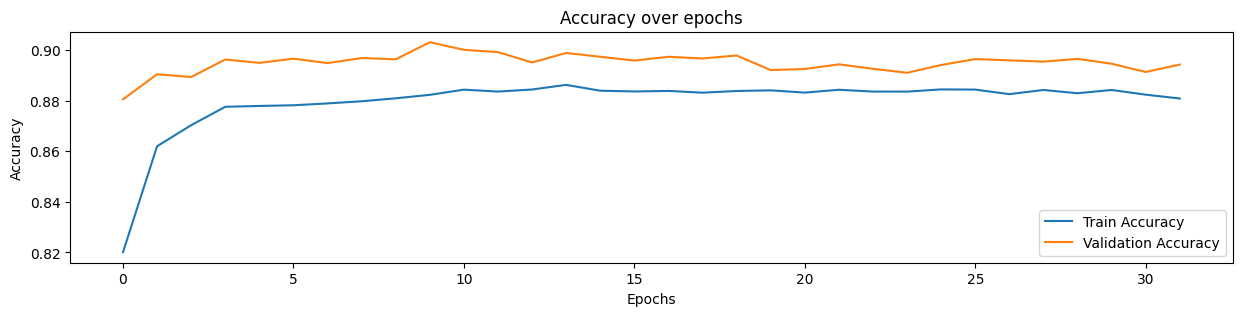

In [33]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history_studentQPKD.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_studentQPKD.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

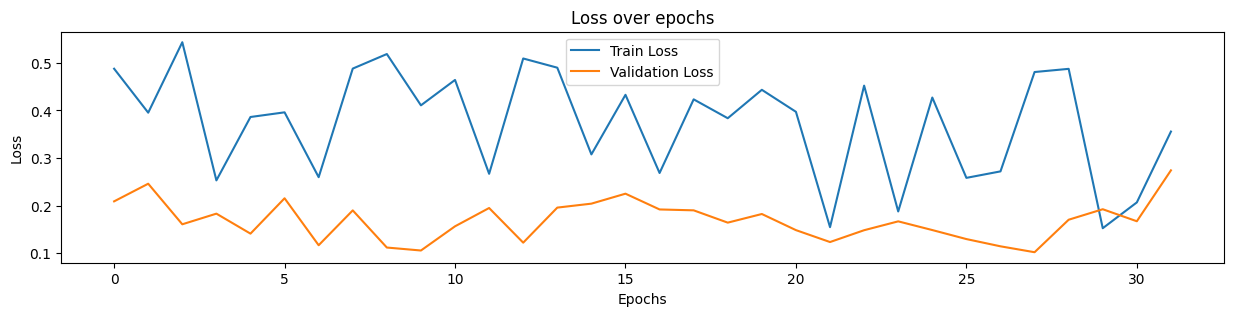

In [34]:
# Plot loss over epochs
plt.figure(figsize=(15,3))
plt.plot(history_studentQPKD.history['student_loss'], label='Train Loss')
plt.plot(history_studentQPKD.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

313/313 [==============================] - 2s 5ms/step


<Figure size 700x700 with 0 Axes>

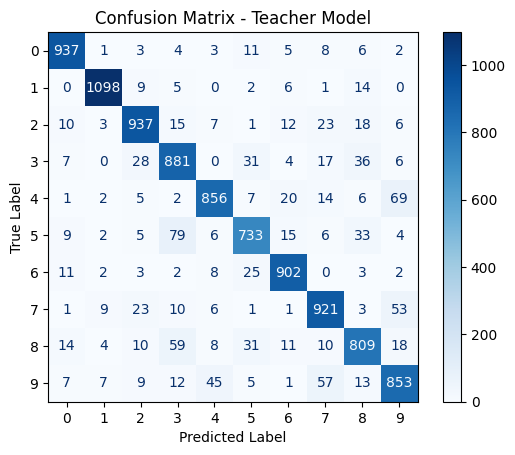

In [35]:
# 1. Predecir probabilidades
y_pred_probs =distilled_student.student.predict(x_test)   # usa x_test de MNIST

# 2. Convertir a etiquetas predichas
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Convertir y_test one-hot a etiquetas reales
y_true = np.argmax(y_test, axis=1)

# 4. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 5. Plot limpio
plt.figure(figsize=(7, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Teacher Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [36]:
student_only = distilled_student.student

test_labels = np.argmax(y_test, axis=1)

student_only.predict(x_test)


313/313 [==============================] - 2s 5ms/step


array([[3.69829126e-04, 7.36539951e-05, 9.69005923e-05, ...,
        9.93274629e-01, 5.99760911e-04, 2.74296477e-03],
       [3.91965150e-04, 8.91825708e-04, 9.75993097e-01, ...,
        8.20240984e-06, 1.52558926e-03, 2.02268842e-04],
       [8.46627756e-07, 9.95544314e-01, 3.63149884e-04, ...,
        1.04016857e-03, 8.73187499e-04, 8.18848348e-05],
       ...,
       [8.81306914e-05, 3.47077585e-04, 1.37748604e-04, ...,
        1.51175475e-02, 1.56579986e-02, 2.34627217e-01],
       [2.81382594e-02, 8.50389304e-04, 5.40268200e-04, ...,
        3.56008568e-05, 1.01588309e-01, 2.21779759e-04],
       [2.23421352e-03, 1.22739439e-04, 4.03281813e-03, ...,
        7.16035913e-07, 1.30219152e-03, 3.16517471e-05]], dtype=float32)

1/1 [==============================] - 0s 24ms/step
Label real: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Predicción: 7
Probabilidades: [[3.6982913e-04 7.3653995e-05 9.6900592e-05 2.1052235e-03 1.3268611e-04
  6.0290814e-04 1.4253927e-06 9.9327469e-01 5.9976085e-04 2.7429650e-03]]


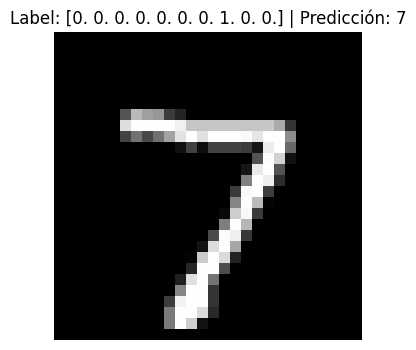

In [37]:
import numpy as np
import matplotlib.pyplot as plt

indexPrediction = 0

# Sacas el vector aplanado (784,)
x_input = x_test[indexPrediction]
y_label = y_test[indexPrediction]

# Para el modelo: necesita (1, 784)
inputPred = np.expand_dims(x_input, axis=0)

# Predicción
y_pred = distilled_student.student.predict(inputPred)
pred_class = np.argmax(y_pred)

print("Label real:", y_label)
print("Predicción:", pred_class)
print("Probabilidades:", y_pred)

# --- Graficar la imagen reconstruida ---
img_2d = x_input.reshape(28, 28)   # <---- ¡IMPORTANTE!

plt.figure(figsize=(4,4))
plt.imshow(img_2d, cmap='gray')
plt.title(f"Label: {y_label} | Predicción: {pred_class}")
plt.axis('off')
plt.show()


In [38]:
model = strip_pruning(distilled_student.student)
model.summary()
model.save('models/CNN/studentModelMnistCNN.h5')

Model: "studentQ_CNN_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv1_act (QActivation)     (None, 26, 26, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 16)        0         
                                                                 
 conv2 (QConv2D)             (None, 11, 11, 32)        4640      
                                                                 
 conv2_act (QActivation)     (None, 11, 11, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 5, 5, 32)          0         
                                                                 
 flatten (Flatten)           (None, 800)          

In [41]:
#!/usr/bin/env python3
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from qkeras import *
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)


# === RUTA LOCAL (ajustada a tu PC) ===
MODEL_DIR = "models/CNN/"


model_files = {
    "student": os.path.join(MODEL_DIR, "studentModelMnistCNN.h5"),
    "teacher": os.path.join(MODEL_DIR, "teacherModelMnistCNN.h5"),
    "teacher_qat": os.path.join(MODEL_DIR, "teacherModelQATMnistCNN.h5")
}

# === Carga MNIST ===
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_test.astype("float32") / 255.0
x_test_flat = x_test.reshape((x_test.shape[0], -1))

results = []

def safe_load_model(path):
    try:
        model = load_model(path,custom_objects=co)
        return model, None
    except Exception as e:
        return None, str(e)

for name, path in model_files.items():
    info = {"model": name, "path": path, "exists": os.path.exists(path)}

    if not os.path.exists(path):
        info["error"] = "file not found"
        results.append(info)
        continue

    info["filesize_bytes"] = os.path.getsize(path)

    model, err = safe_load_model(path)
    if err:
        info["error"] = f"load_error: {err}"
        results.append(info)
        continue

    info["loaded"] = True

    # Parámetros
    info["params_count"] = model.count_params()

    # Sparsity
    weights = model.get_weights()
    total = sum(w.size for w in weights)
    zeros = sum(np.sum(w == 0.0) for w in weights)

    info["weights_total"] = total
    info["weights_zeros"] = zeros
    info["sparsity_fraction"] = zeros / total

    # Evaluación
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    loss, acc = model.evaluate(x_test_flat, y_test, verbose=0)
    info["eval_loss"] = loss
    info["eval_accuracy"] = acc

    # Latencia
    model.predict(x_test_flat[:128], batch_size=128, verbose=0)
    t0 = time.time()
    model.predict(x_test_flat, batch_size=256, verbose=0)
    t1 = time.time()
    info["inference_time_total_s"] = t1 - t0
    info["inference_time_per_sample_ms"] = (t1 - t0) / len(x_test_flat) * 1000

    results.append(info)

# === DataFrame ===
df = pd.DataFrame(results)
print("\n=== Resumen ===")
print(df.to_string(index=False))

# === Gráficas ===
if "eval_accuracy" in df:
    df.set_index("model")["eval_accuracy"].plot(kind="bar",
                                                title="Accuracy MNIST")
    plt.ylabel("Accuracy")
    plt.show()

if "sparsity_fraction" in df:
    df.set_index("model")["sparsity_fraction"].plot(kind="bar",
                                                    title="Sparsity")
    plt.ylabel("Zeros Fraction")
    plt.show()

# === CSV ===
df.to_csv("mnist_summary_cnn.csv", index=False)
print("\nResumen guardado en mnist_summary_cnn.csv")


ValueError: in user code:

    File "/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/engine/training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/engine/training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/engine/training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/engine/training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/pinpa/anaconda3/envs/mf_env/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "studentQ_CNN_MLP" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 784)
